In [1]:
from __future__ import print_function,division
import numpy as np
import nltk
import json
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
from keras.layers import Embedding
import tensorflow as tf
import cPickle as pickle
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
import gensim
from nmt_utils import *
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from gensim.models import KeyedVectors

Using TensorFlow backend.


In [2]:
reviews = pd.read_csv("ConciseReviews.csv", sep=None,)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #",i+1)
    print("Summary: ",reviews.TargetSummary[i],"\n")
    print("Reviews: ",reviews.ConciseMovieReview[i],"\n\n")
    print()

Review # 1
Summary:  a powerful documentarylike examination of the response to an occupying force the battle of algiers has not aged a bit since its release in 1966 

Reviews:  a riveting reconstruction of the struggle for independence in mid-50s algiers, its pseudo-documentary style still feels as headline-fresh as its content. brilliantly directed set-pieces and remarkable thronging crowd scenes make the film a masterpiece; the ominous familiarity of its subject makes it a must-see. gripping, relevant cinemairish film, "bloody sunday," borrowed its entire structure from "algiers". "the battle of algiers" is a one of a kind masterpiece of pure cinema that you will never forget. the film establishes a kinetic documentary effect, making the impact of every shoot-out and explosion a deeply personal experience. this seminal meticulously crafted work about algiers struggle for freedom won the venic film fest top award, and deservedly garnered pontecorvo oscar nominations as best director a

In [4]:
reviews.TargetSummary[182]

'thanks to energetic performances from its young leads gimme the loot captures a slice of city life with warmth and exuberance'

In [5]:
ExtractedReviews=[]
Summaries=[]
ts=[]
for i in range(840):
    ExtractedReviews.append(reviews.ConciseMovieReview[i])
    ts.append(reviews.TargetSummary[i])
    Summaries.append('SOS '+reviews.TargetSummary[i]+' EOS')

In [6]:
Summaries[:3]

['SOS a powerful documentarylike examination of the response to an occupying force the battle of algiers has not aged a bit since its release in 1966 EOS',
 'SOS poor plot development and slow pacing keep 54 from capturing the energy of it is legendary namesake EOS',
 'SOS while it hews closely to the 1984 original craig brewer infuses his footloose remake with toetapping energy and manages to keep the story fresh for a new generation EOS']

In [7]:
extractedtokenizer=Tokenizer(char_level=False)
extractedtokenizer.fit_on_texts(ExtractedReviews)

In [8]:
extractedWord_counts=extractedtokenizer.word_counts

In [9]:
extractedWord_counts

OrderedDict([('a', 16613),
             ('riveting', 80),
             ('reconstruction', 3),
             ('of', 14158),
             ('the', 24059),
             ('struggle', 34),
             ('for', 3339),
             ('independence', 14),
             ('in', 6743),
             ('mid', 18),
             ('50s', 9),
             ('algiers', 5),
             ('its', 2823),
             ('pseudo', 8),
             ('documentary', 426),
             ('style', 254),
             ('still', 446),
             ('feels', 351),
             ('as', 4084),
             ('headline', 4),
             ('fresh', 116),
             ('content', 33),
             ('brilliantly', 73),
             ('directed', 215),
             ('set', 248),
             ('pieces', 65),
             ('and', 14937),
             ('remarkable', 93),
             ('thronging', 1),
             ('crowd', 77),
             ('scenes', 240),
             ('make', 716),
             ('film', 3919),
             ('masterpie

In [10]:
print('No of unique words in extracted Reviews:->',len(extractedWord_counts))

No of unique words in extracted Reviews:-> 25588


In [11]:
summarytokenizer=Tokenizer(char_level=False)
summarytokenizer.fit_on_texts(ts)

In [12]:
summaryWord_counts=summarytokenizer.word_counts
summaryWord_index=summarytokenizer.word_index

In [13]:
summaryWord_index['the']

2

In [14]:
len(summarytokenizer.word_counts)

4866

In [15]:
modiefiedSummaryWord_index=summarytokenizer.word_index
print('Initially vocab size for modified summary is:->',len(modiefiedSummaryWord_index))
modiefiedSummaryWord_index['PAD']=0
print('After adding PAD to vocab, vocab size for modified summary is:->',len(modiefiedSummaryWord_index))
modiefiedSummaryWord_index['SOS']=len(summarytokenizer.word_counts)+1
print('After adding SOS to vocab, vocab size for modified summary is:->',len(modiefiedSummaryWord_index))
modiefiedSummaryWord_index['EOS']=len(summarytokenizer.word_counts)+2
print('After adding EOS to vocab, vocab size for modified summary is:->',len(modiefiedSummaryWord_index))


Initially vocab size for modified summary is:-> 4866
After adding PAD to vocab, vocab size for modified summary is:-> 4867
After adding SOS to vocab, vocab size for modified summary is:-> 4868
After adding EOS to vocab, vocab size for modified summary is:-> 4869


In [16]:
summaryWord_index['battle'],modiefiedSummaryWord_index['battle']

(373, 373)

In [17]:
embeddings = dict()
filename = 'glove.6B/glove.6B.100d.txt'
f = open(filename)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings))

Loaded 400000 word vectors.


In [18]:
print('No of unique words in summaries:->',len(summarytokenizer.word_counts))

No of unique words in summaries:-> 4866


In [19]:
ReviewsVocabSize=len(extractedtokenizer.word_index)+1
SummaryVocabSize=len(summarytokenizer.word_index)+1#actually it is 11279
ModifiedVocabSize=len(modiefiedSummaryWord_index)+1
print('ReviewsVocabSize:->',ReviewsVocabSize)
print('SummaryVocabSize:->',SummaryVocabSize)
print('ModifiedVocabSize:->',ModifiedVocabSize)

ReviewsVocabSize:-> 25589
SummaryVocabSize:-> 4870
ModifiedVocabSize:-> 4870


In [20]:
summaryWord_index['SOS']

4867

In [21]:
modiefiedSummaryWord_index['SOS']

4867

In [22]:
# Find the number of words that are missing in Glove, and are used more than our threshold.
missing_words = 0
thresholdR = 20
thresholdS = 0
check=0#words that repeats less than 20 times but are in embedding_index 
most_good_repeating_words=0
badWords=0# words which repeats less than 20 times and also not in embedding_index
for word, count in extractedWord_counts.items():
    if count <thresholdR:
        if word in embeddings:
            check+=1
    if count <thresholdR:
        if word not in embeddings:
            badWords+=1
            
    if count >=thresholdR:
        if word in embeddings:
            most_good_repeating_words+=1
    if count > thresholdR:
        if word not in embeddings:
            #print(word)
            missing_words += 1
            
missing_ratio = round(missing_words/len(extractedWord_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))
print('check:->',check)
print('most_good_repeating_words',most_good_repeating_words)
print('Bad words',badWords)

Number of words missing from CN: 14
Percent of words that are missing from vocabulary: 0.05%
check:-> 20950
most_good_repeating_words 2607
Bad words 2017


In [23]:
extractedtokenizer.word_index

{'woods': 5451,
 'hanging': 4211,
 'woody': 602,
 'comically': 10673,
 'scold': 12076,
 'originality': 1810,
 'appropriation': 12400,
 'bringing': 1360,
 'wooded': 16461,
 'liaisons': 19556,
 'grueling': 5793,
 'wooden': 7370,
 'circuitry': 20058,
 'crotch': 14366,
 'stereotypical': 25102,
 'gwenns': 19422,
 'insular': 20253,
 'splendiferous': 17601,
 'precocity': 16462,
 'sustaining': 12064,
 'consenting': 22402,
 'scraped': 16876,
 'inanimate': 17468,
 'errors': 13436,
 'cooking': 14568,
 'videodrome': 12964,
 'succumb': 7772,
 'shocks': 4237,
 'brainwashed': 24064,
 '47': 18380,
 'perfunctorily': 18615,
 'china': 3559,
 'natured': 2218,
 'kids': 232,
 'uplifting': 1482,
 'climbed': 19524,
 'controversy': 4161,
 'natures': 14968,
 'spotty': 8787,
 'golden': 1890,
 'projection': 25391,
 'outraging': 15989,
 'darkos': 22207,
 'fantasia2000': 13123,
 'ohorten': 7993,
 'dna': 8000,
 'catchy': 5921,
 'insecurity': 8940,
 'cannibal': 11624,
 'prospector': 23141,
 'music': 261,
 'therefore'

In [24]:
embeddingReviews = np.zeros((ReviewsVocabSize, 100))
embedding_dim=100
for word, i in extractedtokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embeddingReviews[i] = embedding_vector
    else:
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings[word]=new_embedding
        embeddingReviews[i]=new_embedding       

In [25]:
len(embeddingReviews)

25589

In [26]:
encodedReviews=extractedtokenizer.texts_to_sequences(ExtractedReviews)
encodedSummaries=summarytokenizer.texts_to_sequences(Summaries)
#encodedTargetSummaries=ts.texts_to_sequences

In [27]:
encoded_modified_summaries=[]
count=0
for line in Summaries:
    wordList=[]
    count+=1
    #print('count:->',count)
    for word in nltk.word_tokenize(line):
        #print(word)
        if modiefiedSummaryWord_index.has_key(word) !=False:
            wordList.append(modiefiedSummaryWord_index[word])
    encoded_modified_summaries.append(wordList)


In [28]:
print(encoded_modified_summaries[0])

[4867, 3, 60, 1852, 223, 4, 2, 1853, 6, 12, 1854, 1056, 2, 373, 4, 1855, 38, 18, 1856, 3, 449, 739, 9, 1857, 11, 1858, 4868]


In [29]:
print(encodedSummaries[0])

[3, 60, 1852, 223, 4, 2, 1853, 6, 12, 1854, 1056, 2, 373, 4, 1855, 38, 18, 1856, 3, 449, 739, 9, 1857, 11, 1858]


In [30]:
maxReviewLength=200
maxSummaryLength=30

In [31]:
paddedReviews = pad_sequences(encodedReviews, maxlen=maxReviewLength, padding='post',truncating='post')
paddedSummary = pad_sequences(encodedSummaries, maxlen=maxSummaryLength, padding='post',truncating='post')
paddedModifiedSummary = pad_sequences(encoded_modified_summaries, maxlen=maxSummaryLength, padding='post',truncating='post')

In [32]:
print(paddedReviews[290])

[ 4531   706    28     1   694     6  3726   866     3 10431   628     9
  1843  1981  8580     6  9068    43    22    70   529     1    12     5
     2  4651     4    84    56    24   128   335     3     8  1084     2
   773    31   152    22   444    10  4545  1188   130     3   138   675
    29  1820     7  1438 18523     7    16   556  1174    12    44    22
   308    17   255   114   111    22   145  5224     9     1   138   675
  4531   706    90     1    92     4     2  6166  4329    21  1357   219
  2055   254     3  1431  2031  4531   706     5     1  2383     4    19
  3303  4921   587  1437    13   351  1222   504  4531   706    39    17
    23    10  7161    10     1  9068     8  2559    10 10640    61    20
     2 18524   335   201     7     2 10797  9068    16     5     2   412
    73   326   659    21  2018 18525 13532    67   668    12     9  5350
  1099    54     4     1  3222     2   178    12    13     8   877     6
   529     2    34    26     2   545  4702    17   

In [33]:
print(paddedSummary[0])

[   3   60 1852  223    4    2 1853    6   12 1854 1056    2  373    4 1855
   38   18 1856    3  449  739    9 1857   11 1858    0    0    0    0    0]


In [34]:
print(paddedModifiedSummary[0])

[4867    3   60 1852  223    4    2 1853    6   12 1854 1056    2  373    4
 1855   38   18 1856    3  449  739    9 1857   11 1858 4868    0    0    0]


In [35]:
dataIX=paddedReviews
dataTY=paddedSummary
dataIY=paddedModifiedSummary
dataIX.shape,dataIY.shape,dataTY.shape

((840, 200), (840, 30), (840, 30))

In [36]:
nb_samples=len(dataIX)
nb_samples

840

In [37]:
decoderInputSummary=to_categorical(paddedModifiedSummary,num_classes=ModifiedVocabSize)

In [38]:
decoderInputSummary=decoderInputSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [39]:
decoderInputSummary.shape

(840, 30, 4870)

In [40]:
decoderTargetSummary=to_categorical(paddedSummary,num_classes=ModifiedVocabSize)

In [41]:
decoderTargetSummary.shape

(25200, 4870)

In [93]:
testIX=dataIX

In [42]:
decoderTargetSummary=decoderTargetSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [43]:
decoderTargetSummary.shape

(840, 30, 4870)

In [44]:
#Encoder
Encoder_embedding_layer = Embedding(ReviewsVocabSize,
                            embedding_dim,
                            weights=[embeddingReviews],
                            input_length=maxReviewLength,
                            trainable=True)
encoder_input=Input(shape=(maxReviewLength,))
print('encoder_input shape is:->',encoder_input.shape)
embedded_Encoder_inputSequence=Encoder_embedding_layer(encoder_input)
encoder_LSTM=LSTM(256,return_state=True)
encoder_output,encoder_h,encoder_c=encoder_LSTM(embedded_Encoder_inputSequence)
encoder_states=[encoder_h,encoder_c]

encoder_input shape is:-> (?, 200)


In [46]:
decoder_input=Input(shape=(None,ModifiedVocabSize))
#embedded_Decoder_inputSequence=Decoder_embedding_layer(decoder_input)
decoder_LSTM=LSTM(256,return_sequences=True, return_state = True,dropout=0.2)
decoder_output,decoder_h,decoder_c=decoder_LSTM(decoder_input,initial_state=encoder_states)
decoder_dense=Dense(ModifiedVocabSize,activation='softmax')
final_decoder_out=decoder_dense(decoder_output)

In [47]:
model=Model(inputs=[encoder_input,decoder_input],output=final_decoder_out)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [48]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
#filepath="summWithoutAttention.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=False, mode='auto', period=1)
checkpointer = ModelCheckpoint(filepath='SummarizationWithoutAttentionV3.1Weights.hdf5', verbose=1, save_best_only=False,mode='auto',period=1)

#callbacks_list = [checkpoint]

In [49]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 200, 100)      2558900     input_1[0][0]                    
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, None, 4870)    0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    [(None, 256), (None,  365568      embedding_1[0][0]                
___________________________________________________________________________________________

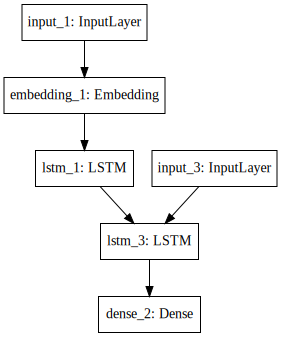

In [50]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [51]:
model.fit(x=[dataIX,decoderInputSummary], 
          y=decoderTargetSummary,
          batch_size=2,
          epochs=400,
          validation_split=0.2,callbacks=[checkpointer])

Train on 672 samples, validate on 168 samples
Epoch 1/400
672/672 [==============================] - 197s - loss: 5.6008 - acc: 0.3118 - val_loss: 5.2974 - val_acc: 0.3240
Epoch 2/400
672/672 [==============================] - 195s - loss: 4.8986 - acc: 0.3213 - val_loss: 5.3094 - val_acc: 0.3250
Epoch 3/400
672/672 [==============================] - 195s - loss: 4.7452 - acc: 0.3283 - val_loss: 5.3537 - val_acc: 0.3317
Epoch 4/400
672/672 [==============================] - 194s - loss: 4.6627 - acc: 0.3313 - val_loss: 5.3922 - val_acc: 0.3337
Epoch 5/400
672/672 [==============================] - 195s - loss: 4.5659 - acc: 0.3367 - val_loss: 5.4355 - val_acc: 0.3403
Epoch 6/400
672/672 [==============================] - 197s - loss: 4.4781 - acc: 0.3430 - val_loss: 5.4898 - val_acc: 0.3411
Epoch 7/400
672/672 [==============================] - 209s - loss: 4.4072 - acc: 0.3474 - val_loss: 5.4811 - val_acc: 0.3442
Epoch 8/400
672/672 [==============================] - 217s - loss: 4.32

672/672 [==============================] - 191s - loss: 3.4175 - acc: 0.4034 - val_loss: 6.0070 - val_acc: 0.3423
Epoch 31/400
672/672 [==============================] - 190s - loss: 3.4019 - acc: 0.4024 - val_loss: 6.0524 - val_acc: 0.3448
Epoch 32/400
672/672 [==============================] - 190s - loss: 3.3715 - acc: 0.4062 - val_loss: 6.0422 - val_acc: 0.3419
Epoch 33/400
672/672 [==============================] - 191s - loss: 3.3408 - acc: 0.4079 - val_loss: 6.0834 - val_acc: 0.3429
Epoch 34/400
672/672 [==============================] - 191s - loss: 3.3177 - acc: 0.4095 - val_loss: 6.0821 - val_acc: 0.3431
Epoch 35/400
672/672 [==============================] - 191s - loss: 3.2891 - acc: 0.4121 - val_loss: 6.0670 - val_acc: 0.3387
Epoch 36/400
672/672 [==============================] - 191s - loss: 3.2644 - acc: 0.4138 - val_loss: 6.1034 - val_acc: 0.3415
Epoch 37/400
672/672 [==============================] - 192s - loss: 3.2368 - acc: 0.4140 - val_loss: 6.1099 - val_acc: 0.34

672/672 [==============================] - 190s - loss: 2.4480 - acc: 0.5397 - val_loss: 6.5342 - val_acc: 0.3260
Epoch 89/400
672/672 [==============================] - 189s - loss: 2.4349 - acc: 0.5419 - val_loss: 6.5191 - val_acc: 0.3262
Epoch 90/400
672/672 [==============================] - 189s - loss: 2.4265 - acc: 0.5425 - val_loss: 6.5176 - val_acc: 0.3252
Epoch 91/400
672/672 [==============================] - 190s - loss: 2.4146 - acc: 0.5461 - val_loss: 6.5324 - val_acc: 0.3258
Epoch 92/400
672/672 [==============================] - 189s - loss: 2.4065 - acc: 0.5471 - val_loss: 6.5310 - val_acc: 0.3256
Epoch 93/400
672/672 [==============================] - 189s - loss: 2.3987 - acc: 0.5489 - val_loss: 6.5405 - val_acc: 0.3248
Epoch 94/400
672/672 [==============================] - 189s - loss: 2.3817 - acc: 0.5521 - val_loss: 6.5402 - val_acc: 0.3244
Epoch 95/400
672/672 [==============================] - 192s - loss: 2.3779 - acc: 0.5536 - val_loss: 6.5437 - val_acc: 0.32

672/672 [==============================] - 191s - loss: 2.0037 - acc: 0.6319 - val_loss: 6.7960 - val_acc: 0.3177
Epoch 147/400
672/672 [==============================] - 190s - loss: 1.9947 - acc: 0.6315 - val_loss: 6.7531 - val_acc: 0.3163
Epoch 148/400
672/672 [==============================] - 189s - loss: 1.9905 - acc: 0.6339 - val_loss: 6.7869 - val_acc: 0.3187
Epoch 149/400
672/672 [==============================] - 189s - loss: 1.9861 - acc: 0.6356 - val_loss: 6.7920 - val_acc: 0.3177
Epoch 150/400
672/672 [==============================] - 190s - loss: 1.9773 - acc: 0.6373 - val_loss: 6.7835 - val_acc: 0.3190
Epoch 151/400
672/672 [==============================] - 189s - loss: 1.9775 - acc: 0.6373 - val_loss: 6.7731 - val_acc: 0.3165
Epoch 152/400
672/672 [==============================] - 191s - loss: 1.9693 - acc: 0.6369 - val_loss: 6.7960 - val_acc: 0.3161
Epoch 153/400
672/672 [==============================] - 190s - loss: 1.9642 - acc: 0.6367 - val_loss: 6.7913 - val_ac

672/672 [==============================] - 191s - loss: 1.7420 - acc: 0.6794 - val_loss: 6.9252 - val_acc: 0.3139
Epoch 205/400
672/672 [==============================] - 201s - loss: 1.7336 - acc: 0.6822 - val_loss: 6.9342 - val_acc: 0.3135
Epoch 206/400
672/672 [==============================] - 191s - loss: 1.7276 - acc: 0.6858 - val_loss: 6.9275 - val_acc: 0.3131
Epoch 207/400
672/672 [==============================] - 195s - loss: 1.7250 - acc: 0.6856 - val_loss: 6.9424 - val_acc: 0.3149
Epoch 208/400
672/672 [==============================] - 191s - loss: 1.7176 - acc: 0.6864 - val_loss: 6.9507 - val_acc: 0.3151
Epoch 209/400
672/672 [==============================] - 190s - loss: 1.7152 - acc: 0.6887 - val_loss: 6.9339 - val_acc: 0.3145
Epoch 210/400
672/672 [==============================] - 202s - loss: 1.7163 - acc: 0.6847 - val_loss: 6.9359 - val_acc: 0.3127
Epoch 211/400
672/672 [==============================] - 196s - loss: 1.7070 - acc: 0.6897 - val_loss: 6.9545 - val_ac

672/672 [==============================] - 195s - loss: 1.5534 - acc: 0.7155 - val_loss: 7.0411 - val_acc: 0.3097
Epoch 263/400
672/672 [==============================] - 205s - loss: 1.5531 - acc: 0.7160 - val_loss: 7.0568 - val_acc: 0.3105
Epoch 264/400
672/672 [==============================] - 201s - loss: 1.5539 - acc: 0.7174 - val_loss: 7.0664 - val_acc: 0.3111
Epoch 265/400
672/672 [==============================] - 201s - loss: 1.5479 - acc: 0.7203 - val_loss: 7.0591 - val_acc: 0.3127
Epoch 266/400
672/672 [==============================] - 196s - loss: 1.5461 - acc: 0.7189 - val_loss: 7.0503 - val_acc: 0.3093
Epoch 267/400
672/672 [==============================] - 204s - loss: 1.5405 - acc: 0.7203 - val_loss: 7.0553 - val_acc: 0.3115
Epoch 268/400
672/672 [==============================] - 205s - loss: 1.5399 - acc: 0.7187 - val_loss: 7.0664 - val_acc: 0.3105
Epoch 269/400
672/672 [==============================] - 199s - loss: 1.5357 - acc: 0.7192 - val_loss: 7.0529 - val_ac

672/672 [==============================] - 212s - loss: 1.4220 - acc: 0.7436 - val_loss: 7.1289 - val_acc: 0.3093
Epoch 321/400
672/672 [==============================] - 204s - loss: 1.4235 - acc: 0.7424 - val_loss: 7.1401 - val_acc: 0.3087
Epoch 322/400
672/672 [==============================] - 200s - loss: 1.4171 - acc: 0.7430 - val_loss: 7.1459 - val_acc: 0.3095
Epoch 323/400
672/672 [==============================] - 202s - loss: 1.4184 - acc: 0.7435 - val_loss: 7.1346 - val_acc: 0.3079
Epoch 324/400
672/672 [==============================] - 194s - loss: 1.4181 - acc: 0.7428 - val_loss: 7.1330 - val_acc: 0.3089
Epoch 325/400
672/672 [==============================] - 195s - loss: 1.4152 - acc: 0.7430 - val_loss: 7.1471 - val_acc: 0.3093
Epoch 326/400
672/672 [==============================] - 198s - loss: 1.4077 - acc: 0.7433 - val_loss: 7.1442 - val_acc: 0.3075
Epoch 327/400
672/672 [==============================] - 203s - loss: 1.4137 - acc: 0.7455 - val_loss: 7.1354 - val_ac

672/672 [==============================] - 200s - loss: 1.3243 - acc: 0.7620 - val_loss: 7.1981 - val_acc: 0.3063
Epoch 379/400
672/672 [==============================] - 206s - loss: 1.3220 - acc: 0.7624 - val_loss: 7.2079 - val_acc: 0.3071
Epoch 380/400
672/672 [==============================] - 200s - loss: 1.3200 - acc: 0.7620 - val_loss: 7.2010 - val_acc: 0.3071
Epoch 381/400
672/672 [==============================] - 197s - loss: 1.3160 - acc: 0.7623 - val_loss: 7.2021 - val_acc: 0.3065
Epoch 382/400
672/672 [==============================] - 194s - loss: 1.3141 - acc: 0.7644 - val_loss: 7.1983 - val_acc: 0.3062
Epoch 383/400
672/672 [==============================] - 206s - loss: 1.3171 - acc: 0.7624 - val_loss: 7.1997 - val_acc: 0.3065
Epoch 384/400
672/672 [==============================] - 205s - loss: 1.3086 - acc: 0.7666 - val_loss: 7.2106 - val_acc: 0.3058
Epoch 385/400
672/672 [==============================] - 205s - loss: 1.3062 - acc: 0.7654 - val_loss: 7.2050 - val_ac

# Inferencing

In [52]:
#Encoder Inference
encoder_model_inf=Model(inputs=encoder_input,outputs=encoder_states)

In [53]:
#Decoder Inference
decoder_state_input_h=Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]
decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input,initial_state=decoder_input_states)
decoder_states=[decoder_h,decoder_c]
decoder_inf_final_out = decoder_dense(decoder_out)
decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_inf_final_out] + decoder_states )

In [54]:
modiefiedSummaryWord_index['SOS']

4867

In [55]:
int_to_vocab_summaries = {}
for word, value in modiefiedSummaryWord_index.items():
    int_to_vocab_summaries[value] = word

In [60]:
def decode_seq(input_seq):
    # Initial states value is coming from the encoder 
    #We get the encoder states into states_val variable
    states_val = encoder_model_inf.predict(input_seq)#return encoder states
    target_seq = np.zeros((1,1,ModifiedVocabSize))
    print('target_seq shape:->',target_seq.shape)
    target_seq[0, 0, modiefiedSummaryWord_index['SOS']] = 1
    print(target_seq.shape)
    #target_seq=embeddingModifiedSummaries[modiefiedSummaryWord_index['SOS']]
    summarized_sent = ''
    stop_condition = False
    i=1
    while not stop_condition:
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        #print(decoder_out)
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_summary_word = int_to_vocab_summaries[max_val_index]
        #print('sampled_summary_word is:->',sampled_summary_word)
        #print()
        summarized_sent += sampled_summary_word+" "
        #print('summarized_sent is:->',summarized_sent)
        #print()
        if ((sampled_summary_word == 'EOS') or (len(summarized_sent) >= maxSummaryLength)) :
            print('terminated')
            stop_condition = True
        
        target_seq = np.zeros((1,1,ModifiedVocabSize))
        target_seq[0, 0, max_val_index]=1
        
        states_val = [decoder_h, decoder_c]
        i=i+1
        
    return summarized_sent

In [83]:
human_summary=[]
for i in range(50):    
    #print('System Generated Summary:',summary)
    temp=[]
    for j in range(len(paddedSummary[i])):
        temp.append(int_to_vocab_summaries[paddedSummary[i][j]])
    human_summary.append(temp)    
humanSummary=" "        
for i in range(50):
    data=dataIX[i].reshape(1,200)
    summary=decode_seq(data)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    humanSummary=" "
   

target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: a powerful documentarylike of 
Human Summary  a powerful documentarylike examination of the response to an occupying force the battle of algiers has not aged a bit since its release in 1966 PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: though and repetitive and his 
Human Summary  poor plot development and slow pacing keep 54 from capturing the energy of it is legendary namesake PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: it is nasty closely to the 1984 
Human Summary  while it hews closely to the 1984 original craig brewer infuses his footloose remake with toetapping energy and manages to keep the story fresh for a new generation PAD PAD 
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: though acted and an searing in 
Huma

terminated
System Generated Summary: the landmark of hook of a huge 
Human Summary  while fast times at ridgemont high features sean penns legendary performance the film endures because it accurately captured the small details of school work and teenage life PAD PAD PAD 
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: an longoverdue of japanese perros 
Human Summary  this longoverdue return from alejandro jodorowsky finds him just as overflowing with imagination and heart as fans have come to expect PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: a few rousing thriller that that 
Human Summary  a few rousing action sequences cannot make up for pathfinders nonexistent plot and silly dialogue PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: though it is a pleasures to reflect 
Human Summar

In [84]:
from nltk.translate.bleu_score import sentence_bleu

In [96]:
humanSummary=" "  
scores=[]
for i in range(50):
    testData=testIX[i].reshape(1,200)
    summary=decode_seq(testData)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    #calculation of bleu score
    score=sentence_bleu(summary,humanSummary,weights=(0.5, 0.5, 0, 0))
    print('BlEU SCORE IS:->',score)
    scores.append(score)      
    humanSummary=" "

total=0
for i in scores:
    total+=i
print('AVERAGE BLEU SCORE:->',total/len(scores))   

target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: a powerful documentarylike of 
Human Summary  a powerful documentarylike examination of the response to an occupying force the battle of algiers has not aged a bit since its release in 1966 PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.330289129538
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: though and repetitive and his 
Human Summary  poor plot development and slow pacing keep 54 from capturing the energy of it is legendary namesake PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.313112145543
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: it is nasty closely to the 1984 
Human Summary  while it hews closely to the 1984 original craig brewer infuses his footloose remake with toetapping energy and manages to keep the story fresh for a new generation PAD PAD 
BlEU SCORE IS:-> 0.303239217432
target_seq shape:-> (1,

target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: though in the heartfelt in sessions 
Human Summary  in addition to its breathtaking underwater photography sharkwater has a convincing impassioned argument of how the plight of sharks affects everyone PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.274351630584
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: the undiscovered is is a anarchic 
Human Summary  better off dead is an anarchic mix of black humor and surreal comedy anchored by john cusacks winsome charming performance PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.281546253186
target_seq shape:-> (1, 1, 4870)
(1, 1, 4870)
terminated
System Generated Summary: the landmark of hook of a huge 
Human Summary  while fast times at ridgemont high features sean penns legendary performance the film endures because it accurately captured the small details of school work and teenage life PAD PAD PAD 
